# Acinar Detection from Brightifield Images
- *Isobel Taylor-Hearn, 2024*
- The code contains two segmentation methods. One is based on intensity, one is edge-based.
- Intensity-based segmentation works best for WT acini. However, if you're having issues with the masks not aligning well with the cells, you can try the edge based segmentation

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pathlib
import contextlib
import joblib
from tqdm import tqdm
from joblib import Parallel, delayed

from tifffile import imread
from skimage import util,  restoration
from skimage.filters import gaussian, laplace, threshold_triangle
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import remove_small_holes, remove_small_objects, closing,  disk, erosion

import warnings
warnings.filterwarnings("ignore")

In [ ]:
### IGNORE THIS BIT - This just lets you run loads of jobs in parallel (speeds everything up)
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """
    This allows you to see a progress bar when you run multiple jobs in parallel
    Don't edit this!

    Parameters:
        tqdm_object (tqdm.tqdm): An instance of a `tqdm` progress bar to update.

    Yields:
        tqdm.tqdm: A progress bar that is updated during job execution.
    """
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [ ]:
def add_cell_details(df, filename):
    """
    Fills the output DataFrame with experimental details extracted from the filename

    This function adds three new columns to the input DataFrame:
    - 'cell_type': classified as 'WT' or 'HER2' based on substrings in the filename.
    - 'stiffness': classified as 'soft' or 'stiff' based on substrings in the filename.
    - 'day': the experimental day (integer), extracted from day-related substrings in the filename.
    
    Parameters:
        df (pd.DataFrame): A DataFrame to be annotated.
        filename (str): A string representing the filename from which metadata is extracted.
    
    Returns:
        pd.DataFrame: The input DataFrame with added columns: 'cell_type', 'stiffness', and 'day'.
    """
    filename = filename.lower()
    if ("wt" in filename) or ("well1" in filename.replace("_","")) or ("well2" in filename.replace("_","")) :
        df["cell_type"] = "WT"
    elif ("her2" in filename) or ("well3" in filename.replace("_","")) or ("well4" in filename.replace("_","")) :
        df["cell_type"] = "HER2"
    else:
        df["cell_type"] = "WT"
    if ("soft" in filename) or ("well1" in filename.replace("_","")) or ("well3" in filename.replace("_","")) :
        df["stiffness"] = "soft"
    elif "stiff" in filename or ("well2" in filename.replace("_","")) or ("well4" in filename.replace("_","")):
        df["stiffness"] = "stiff"
    else:
        df["stiffness"] = "ERROR"
    if "d10" in filename.lower():
        df["day"] = 10
    elif ("d12" in filename.lower()) or ("day12" in filename.lower()):
        df["day"] = 12
    elif "d1" in filename.lower():
        df["day"] = 1
    elif "d3" in filename.lower():
        df["day"] = 3
    elif "d5" in filename.lower():
        df["day"] = 5
    elif "d7" in filename.lower():
        df["day"] = 7
    else:
        df["day"] = "ERROR"
    return df

In [ ]:
def intensity_based_segmentation(i, repeat_root, to_plot =True, pixel_size = 0.82804): #you can change the pixel size to actually align with the EVOS
    """
    Segment acini structures from grayscale microscopy images using intensity-based filtering.

    This function processes the i-th image within the specified directory using background subtraction,
    smoothing, thresholding, and morphological cleaning. It generates labeled segmentations of acini 
    and optionally overlays them on the original image for visual inspection. 

    Parameters:
        i (int): Index of the image to process in the repeat_root directory.
        repeat_root (str or Path): Root folder containing .tif images for segmentation.
        to_plot (bool): Whether to display and save a visualization of the segmentation (default: True).
        pixel_size (float): Pixel size in microns for area conversion (default: 0.82804).

    Returns:
        pd.DataFrame: A DataFrame containing region properties for each segmented acinus.
                      If segmentation fails, returns an empty DataFrame.
    """
    try:    
        image_paths = list(pathlib.Path(repeat_root).glob("**/*.tif"))
        img = imread(image_paths[i])
        filename = os.path.basename(image_paths[i]).split(".")[0]

        # Background subtraction and preprocessing
        background_inverted = restoration.rolling_ball(util.invert(img), radius=10)
        processed = util.invert(util.invert(img) - background_inverted)
        blurred = gaussian(processed, sigma=2)
        inverted = util.invert(blurred)
        binary = inverted > threshold_triangle(inverted)

        # Morphological cleaning
        binary = remove_small_holes(binary, area_threshold=100000)
        binary = erosion(binary, disk(2))
        binary = remove_small_objects(binary, min_size=500)

        # Label and clean segmented objects
        acini = label(binary)
        acini = clear_border(acini)

        # Area-based color map for visualization
        props = regionprops_table(acini, properties=('label', 'area'))
        acini_colored = util.map_array(acini, props["label"], props["area"].astype(float))
        acini_colored[acini_colored == 0] = np.nan

        if to_plot:
            fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
            ax[0].imshow(img, cmap='gray')
            ax[1].imshow(acini_colored, cmap="jet", alpha=0.8, interpolation="none")
            ax[1].imshow(processed, cmap="gray", alpha=0.5)
            for region in regionprops(acini):
                ax[1].text(x=region.centroid[1], y=region.centroid[0], s=region.label,
                            color="black", fontsize="x-small", fontweight="bold")
            for a in ax:
                a.axis('off')
            plt.suptitle(f"Intensity-Based Acini Segmentation for {filename}", y=0.95)
            plt.savefig(os.path.join(repeat_root, "Masks", f"{filename}_acini_segmentation_intensity.png"),
                        bbox_inches="tight")

        # Extract region properties
        acinar_props = pd.DataFrame(regionprops_table(acini, properties=('label', 'area', 'eccentricity')))
        acinar_props["area_um"] = acinar_props["area"] * pixel_size**2
        acinar_props["filename"] = filename
        acinar_props["segmentation_type"] = "intensity"
        acinar_props = add_cell_details(acinar_props, filename)

        return acinar_props

    except Exception as e:
        print(f"Error processing image index {i}: {e}")
        return pd.DataFrame()

In [ ]:
def edge_based_segmentation(i, repeat_root, to_plot=True, pixel_size=0.82804):
    """
    Segment acini structures using an edge-based approach from grayscale microscopy images.

    This function applies Laplacian edge detection, combines it with intensity information, 
    and refines the binary segmentation using morphological operations. Segmented regions 
    are filtered based on solidity to exclude fragmented or non-compact objects.

    Parameters:
        i (int): Index of the image to process in the repeat_root directory.
        repeat_root (str or Path): Root folder containing .tif images for segmentation.
        to_plot (bool): Whether to display and save a visualization of the segmentation (default: True).
        pixel_size (float): Pixel size in microns for area conversion (default: 0.82804).

    Returns:
        pd.DataFrame: A DataFrame containing region properties for each segmented acinus.
                      If segmentation fails, returns an empty DataFrame.
    """
    try:
        image_paths = list(pathlib.Path(repeat_root).glob("**/*.tif"))
        original = imread(image_paths[i])
        test = imread(image_paths[i])
        filename = os.path.basename(image_paths[i]).split(".")[0]

        # Background subtraction and intensity preparation
        background_inverted = restoration.rolling_ball(util.invert(test), radius=5)
        test_processed = util.invert(util.invert(test) - background_inverted)
        blurred = gaussian(test_processed, sigma=2)
        inverted = util.invert(blurred)

        # Edge detection
        edges = util.invert(laplace(gaussian(test_processed, sigma=15)))
        combined = (10 * edges) + inverted

        # Threshold and clean
        binary = combined > threshold_triangle(combined)
        binary = closing(binary, disk(10))
        binary = remove_small_holes(binary, area_threshold=100000)
        binary = erosion(binary, disk(3))
        binary = remove_small_objects(binary, min_size=1000)

        # Label and filter by solidity
        labels = label(binary)
        props = regionprops_table(labels, properties=('label', 'solidity'))
        condition = props['solidity'] >= 0.4
        input_labels = props['label']
        output_labels = input_labels * condition
        labels = util.map_array(labels, input_labels, output_labels)
        labels = clear_border(labels)

        # For display
        props_area = regionprops_table(labels, properties=('label', 'area'))
        area_overlay = util.map_array(labels, props_area["label"], props_area["area"].astype(float))
        area_overlay[area_overlay == 0] = np.nan

        if to_plot:
            fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
            ax[0].imshow(original, cmap='gray')
            ax[1].imshow(area_overlay, cmap='jet', alpha=0.8, interpolation='none')
            ax[1].imshow(original, cmap='gray', alpha=0.5)

            for region in regionprops(labels):
                ax[1].text(x=region.centroid[1], y=region.centroid[0], s=region.label,
                           color="black", fontsize="x-small", fontweight="bold")

            for a in ax:
                a.axis('off')

            plt.suptitle(f"Edge-Based Acini Segmentation for {filename}", y=0.95)
            plt.savefig(os.path.join(repeat_root, "Masks", f"{filename}_acini_segmentation_edge.png"),
                        bbox_inches="tight")

        # Extract properties
        acinar_props = pd.DataFrame(regionprops_table(labels, properties=('label', 'area', 'eccentricity')))
        acinar_props["area_um"] = acinar_props["area"] * pixel_size**2
        acinar_props["filename"] = filename
        acinar_props["segmentation_type"] = "phase"
        acinar_props = add_cell_details(acinar_props, filename)

        return acinar_props

    except Exception as e:
        print(f"Error processing image index {i}: {e}")
        return pd.DataFrame()

In [ ]:
root= "C:\\Users\\isobe\\The University of Manchester Dropbox\\Isobel Taylor-Hearn\\Her2_Acini_OE\\" # change this to whatever folder your images are in
image_paths = list(pathlib.Path(root).rglob("*.{}".format("tif"))) # make sure to specify the correct image file type
print(len(image_paths)) # double check this is the right number of images to analyse

240


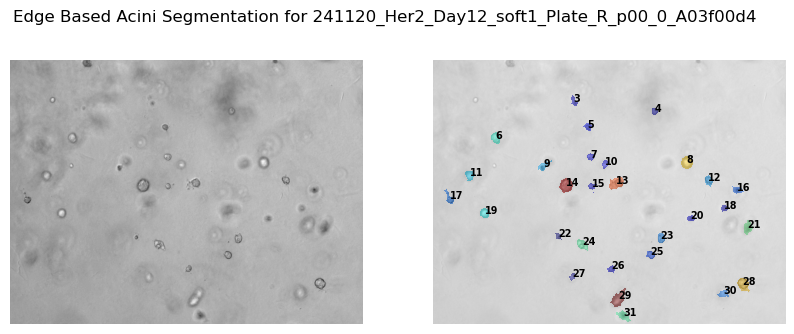

In [ ]:
test_output = edge_based_segmentation(100, root, to_plot = True) #single image - check the masks match what you expect! 

In [ ]:
test_output

,label,area,eccentricity,area_um,filename,segmentation_type,cell_type,stiffness,day
0,2,1226,0.509032,840.607196,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
1,3,1642,0.331281,1125.837697,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
2,5,1800,0.559173,1234.170435,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
3,6,2990,0.595599,2050.094222,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
4,7,1489,0.592420,1020.933210,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
5,8,2122,0.512753,1454.949813,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
6,10,3061,0.913153,2098.775390,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
7,11,1725,0.376718,1182.746667,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
8,12,960,0.847518,658.224232,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1
9,14,1820,0.140399,1247.883440,D1_Eph4_Her2OE_Stiff1_Plate_R_p00_0_A04f00d4,phase,HER2,stiff,1


In [ ]:
data_name = "repeat1"
with tqdm_joblib(tqdm(desc="Image Analysis", total=len(image_paths))) as progress_bar:
    test = Parallel(n_jobs=4)(delayed(edge_based_segmentation)(i, root) for i in range(len(list(pathlib.Path(root).glob("**/*.tif"))))) #change n_jobs to smaller if your PC can't handle it, or larger if you have a powerful PC
total = pd.concat(test)
total.to_csv("Edge_based_acini_segmentation_{}.csv".format(data_name)) # this is the output file with all the acini properties. It will be saved in the same folder as this python file.

Image Analysis: 100%|██████████| 240/240 [03:25<00:00,  1.17it/s]


In [ ]:
data_name = "repeat1"
with tqdm_joblib(tqdm(desc="Image Analysis", total=len(image_paths))) as progress_bar:
    test = Parallel(n_jobs=4)(delayed(intensity_based_segmentation)(i, root) for i in range(len(list(pathlib.Path(root).glob("**/*.tif"))))) #change n_jobs to smaller if your PC can't handle it, or larger if you have a powerful PC
total = pd.concat(test)
total.to_csv("Intensity_based_acini_segmentation_{}.csv".format(data_name)) # this is the output file with all the acini properties. It will be saved in the same folder as this python file.

Image Analysis: 100%|██████████| 240/240 [01:51<00:00,  2.16it/s]
